In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch 
import torch.nn as nn

In [3]:
taxi = pd.read_csv("cleaned_NYCTaxi.csv")

In [4]:
taxi.head()

,journey_distance,am_or_pm,day_of_week,pickup_hour,passenger_count,fare_amount
0,2.126312,AM,Mon,4,1,6.5
1,1.392307,AM,Sat,11,1,6.9
2,3.326763,AM,Sat,7,2,10.1
3,1.864129,PM,Sun,17,1,8.9
4,7.231321,PM,Fri,22,1,19.7


In [5]:
cat_cols = ['am_or_pm','day_of_week','pickup_hour']
cont_cols = ['journey_distance','passenger_count']
label = ['fare_amount']

In [6]:
for i in cat_cols:
    taxi[i] = taxi[i].astype('category',)

In [7]:
taxi.dtypes

journey_distance     float64
am_or_pm            category
day_of_week         category
pickup_hour         category
passenger_count        int64
fare_amount          float64
dtype: object

In [8]:
cat_data = np.stack([taxi[i].cat.codes.values for i in cat_cols],axis = 1)

In [9]:
cat_data

array([[ 0,  1,  4],
       [ 0,  2, 11],
       [ 0,  2,  7],
       ...,
       [ 1,  3, 14],
       [ 0,  5,  4],
       [ 1,  2, 12]], dtype=int8)

In [10]:
cont_data = np.stack([taxi[i].values for i in cont_cols],axis = 1)

In [11]:
cat = torch.tensor(cat_data,dtype = torch.int64).cuda()

In [12]:
cont = torch.tensor(cont_data,dtype = torch.float32).cuda()

In [13]:
cont

tensor([[2.1263, 1.0000],
        [1.3923, 1.0000],
        [3.3268, 2.0000],
        ...,
        [5.0525, 3.0000],
        [1.2089, 1.0000],
        [1.4274, 3.0000]], device='cuda:0')

In [14]:
Y = torch.tensor(taxi['fare_amount'].values,dtype = torch.float32).cuda().reshape(1,-1)

In [15]:
Y = Y.reshape((-1,1))

In [16]:
Y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]], device='cuda:0')

In [17]:
cat.shape

torch.Size([120000, 3])

In [18]:
cont.shape

torch.Size([120000, 2])

In [19]:
Y.shape

torch.Size([120000, 1])

In [20]:
cat_szs = [len(taxi[i].cat.categories) for i in cat_cols]
emb_szs = [(i,min(50,(i+1)//2)) for i in cat_szs]


In [21]:
emb_szs

[(2, 1), (7, 4), (24, 12)]

In [22]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [23]:
model = TabularModel(emb_szs,cont.shape[1],1,[200,100],p = 0.4)
model = model.cuda()

In [24]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(7, 4)
    (2): Embedding(24, 12)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [25]:
next(model.parameters()).is_cuda

True

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [27]:
batch_size = 120000
test_size = 40000
cat_train = cat[:batch_size-test_size]
cat_test = cat[batch_size-test_size:]
cont_train = cont[:batch_size-test_size]
cont_test = cont[batch_size-test_size:]
Y_train = Y[:batch_size - test_size]
Y_test = Y[batch_size-test_size:]


In [28]:
print(cat_train.shape,cont_train.shape,Y_train.shape)
print(cat_test.shape,cont_test.shape,Y_test.shape)
print(cat_train.dtype,cont_train.dtype,Y_train.dtype)
print(cat_test.dtype,cont_test.dtype,Y_test.dtype)

torch.Size([80000, 3]) torch.Size([80000, 2]) torch.Size([80000, 1])
torch.Size([40000, 3]) torch.Size([40000, 2]) torch.Size([40000, 1])
torch.int64 torch.float32 torch.float32
torch.int64 torch.float32 torch.float32


In [29]:
print(cat_train.device,cat_train.device,cat_test.device,cont_test.device,Y_test.device,Y_train.device)

cuda:0 cuda:0 cuda:0 cuda:0 cuda:0 cuda:0


In [30]:
import time
start_time = time.time()
epochs = 450
losses = []
for i in range(epochs):
    Y_pred = model.forward(cat_train,cont_train)
    loss = torch.sqrt(criterion(Y_pred,Y_train))
    losses.append(loss)
    if (i+1)%25 == 0:
        print(f'epoch {i+1} : loss : {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f'epoch: {i:3}  loss: {loss.item()}')
print(f'\nDuration: {(time.time() - start_time)/60} minutes') 

epoch 25 : loss : 11.418351173400879
epoch 50 : loss : 10.355751991271973
epoch 75 : loss : 9.522114753723145
epoch 100 : loss : 8.783745765686035
epoch 125 : loss : 7.9070353507995605
epoch 150 : loss : 6.82925271987915
epoch 175 : loss : 5.615904808044434
epoch 200 : loss : 4.532116413116455
epoch 225 : loss : 3.8673431873321533
epoch 250 : loss : 3.663058280944824
epoch 275 : loss : 3.6363580226898193
epoch 300 : loss : 3.5926530361175537
epoch 325 : loss : 3.5821235179901123
epoch 350 : loss : 3.55942702293396
epoch 375 : loss : 3.549145460128784
epoch 400 : loss : 3.536487340927124
epoch 425 : loss : 3.5182230472564697
epoch 450 : loss : 3.4976136684417725
epoch: 449  loss: 3.4976136684417725

Duration: 0.9860475858052572 minutes


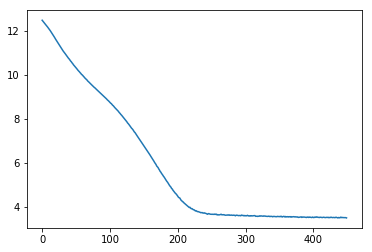

In [33]:
plt.plot(losses)

In [34]:
with torch.no_grad():
    Y_pred = model(cat_test,cont_test)
    loss = torch.sqrt(criterion(Y_test,Y_pred))
print(f'RMSE : {loss}')

RMSE : 3.4925832748413086


In [39]:
Y_pred_cpu = Y_pred.detach().cpu()

In [41]:
Y_test_cpu = Y_test.detach().cpu()

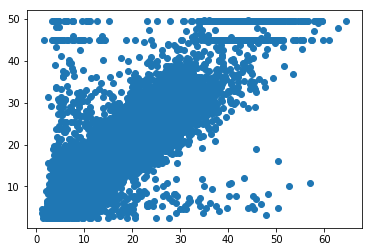

In [42]:
plt.scatter(Y_pred_cpu.numpy(),Y_test_cpu.numpy())

In [43]:
torch.save(model.state_dict(),'model.pt')